# Run SurvTRACE on GBSG, Metabric, Support  datasets

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, sys
sys.path.append(os.path.abspath('../SurvTRACE'))
sys.path.append(os.path.abspath(".."))

In [4]:
import pdb
from collections import defaultdict
import matplotlib.pyplot as plt

from survtrace.dataset import load_data
from survtrace.evaluate_utils import Evaluator
from survtrace.utils import set_random_seed
from survtrace.model import SurvTraceSingle
from survtrace.train_utils import Trainer
from survtrace.config import STConfig
import prettytable as pt

In [5]:
# Hyper params for transformer training
hparams = {
    'batch_size': 64,
    'weight_decay': 0.0,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [6]:
DATASETS = ['gbsg', 'metabric', 'support']

In [7]:
from btdsa.utils import create_logger
logger = create_logger('./logs_survtrace')

In [8]:
horizons = STConfig.horizons
headers = []
results = []

In [9]:
def run_experiment(dataset, hparams, show_plot=False):
    
    assert dataset in DATASETS
    logger.info(f"Running {dataset}...")
    headers.append(dataset)

    # define the setup parameters
    STConfig.data = dataset
    STConfig.early_stop_patience = 10

    #seed = STConfig.seed # 1234
    seed = 42
    set_random_seed(seed)
    
    # load data
    df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

    # get model
    model = SurvTraceSingle(STConfig)

    # initialize a trainer
    trainer = Trainer(model)
    train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
            batch_size=hparams['batch_size'],
            epochs=hparams['epochs'],
            learning_rate=hparams['learning_rate'],
            weight_decay=hparams['weight_decay'],)
    
    # evaluate model
    evaluator = Evaluator(df, df_train.index)
    result_dict = evaluator.eval(model, (df_test, df_y_test), confidence=.95, nb_bootstrap=100)
    
    # Messages for pretty table summary
    cindex_mean, (cindex_lower, cindex_upper) = result_dict.pop('C-td-full')
    row_str = f"C-td (full): {cindex_mean:.6f} ({cindex_lower:.6f},{cindex_upper:.6f})\n"
    
    for horizon in horizons:
        keys = [ k for k in result_dict.keys() if k.startswith(str(horizon)) ]
        results_at_horizon = [result_dict[k] for k in keys]
        msg = [f"[{horizon*100}%]"]
        for k,res in zip(keys,results_at_horizon):
            metric = k.split('_')[1]
            mean, (lower, upper) = res
            msg.append(f"{metric}: {mean:.6f} ({lower:.6f},{upper:.6f})")
        row_str += (" ".join(msg) + "\n")
    results.append(row_str)
        
    if show_plot:
        # show training curves
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend(fontsize=20)
        plt.xlabel('epoch',fontsize=20)
        plt.ylabel('loss', fontsize=20)
        plt.show()
    print("done")

In [10]:
for dataset in DATASETS:
    run_experiment(dataset, hparams, show_plot=False)

Running gbsg...


use pytorch-cuda for training.
[Train-0]: 40.09908926486969
[Val-0]: 1.795464038848877
[Train-1]: 31.27235436439514
[Val-1]: 1.2902237176895142
[Train-2]: 28.2702054977417
[Val-2]: 1.2813656330108643
[Train-3]: 28.171855568885803
[Val-3]: 1.2697116136550903
[Train-4]: 27.965640783309937
[Val-4]: 1.2740832567214966
EarlyStopping counter: 1 out of 10
[Train-5]: 28.073654651641846
[Val-5]: 1.2769994735717773
EarlyStopping counter: 2 out of 10
[Train-6]: 27.909841179847717
[Val-6]: 1.2700824737548828
EarlyStopping counter: 3 out of 10
[Train-7]: 27.763140320777893
[Val-7]: 1.2607190608978271
[Train-8]: 27.696669101715088
[Val-8]: 1.2683457136154175
EarlyStopping counter: 1 out of 10
[Train-9]: 27.704071044921875
[Val-9]: 1.2833281755447388
EarlyStopping counter: 2 out of 10
[Train-10]: 27.737603306770325
[Val-10]: 1.272808313369751
EarlyStopping counter: 3 out of 10
[Train-11]: 27.539986491203308
[Val-11]: 1.274746060371399
EarlyStopping counter: 4 out of 10
[Train-12]: 27.584269404411316


Running metabric...


0.95 confidence C-td-full average: 0.42508174219033257
0.95 confidence C-td-full interval: (0.42104030318236785,0.4291231811982973)
0.95 confidence 0.25_Ctd_ipcw average: 0.7494041244315938
0.95 confidence 0.25_Ctd_ipcw interval: (0.7441975439217982,0.7546107049413894)
0.95 confidence 0.25_brier average: 0.10272065034826204
0.95 confidence 0.25_brier interval: (0.10110377714154777,0.10433752355497632)
0.95 confidence 0.25_auroc average: 0.7678122158234711
0.95 confidence 0.25_auroc interval: (0.7622857479877281,0.7733386836592142)
0.95 confidence 0.5_Ctd_ipcw average: 0.7062904882979819
0.95 confidence 0.5_Ctd_ipcw interval: (0.7025818905452635,0.7099990860507003)
0.95 confidence 0.5_brier average: 0.1754065201097754
0.95 confidence 0.5_brier interval: (0.17376565736824645,0.17704738285130434)
0.95 confidence 0.5_auroc average: 0.7341379918066419
0.95 confidence 0.5_auroc interval: (0.7300240929509765,0.7382518906623072)
0.95 confidence 0.75_Ctd_ipcw average: 0.688692242227709
0.95 con

Running support...


0.95 confidence C-td-full average: 0.38036345160192025
0.95 confidence C-td-full interval: (0.376149008237893,0.3845778949659475)
0.95 confidence 0.25_Ctd_ipcw average: 0.6990424512809237
0.95 confidence 0.25_Ctd_ipcw interval: (0.6930633038382236,0.7050215987236238)
0.95 confidence 0.25_brier average: 0.11852989934595909
0.95 confidence 0.25_brier interval: (0.1167646283444605,0.12029517034745768)
0.95 confidence 0.25_auroc average: 0.7088139306559873
0.95 confidence 0.25_auroc interval: (0.7023951137092376,0.715232747602737)
0.95 confidence 0.5_Ctd_ipcw average: 0.6661444893643379
0.95 confidence 0.5_Ctd_ipcw interval: (0.6619358884004575,0.6703530903282183)
0.95 confidence 0.5_brier average: 0.19430366617534087
0.95 confidence 0.5_brier interval: (0.1926093027675533,0.19599802958312842)
0.95 confidence 0.5_auroc average: 0.6871639711889259
0.95 confidence 0.5_auroc interval: (0.6820669083477489,0.692261034030103)
0.95 confidence 0.75_Ctd_ipcw average: 0.645810008736889
0.95 confiden

In [11]:
tb = pt.PrettyTable(title="SurvTrace")
tb.field_names = headers
tb.add_row(results)
logger.info(tb)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                         SurvTrace                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------

In [12]:
STConfig.data = 'metabric'

# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
        batch_size=hparams['batch_size'],
        epochs=hparams['epochs'],
        learning_rate=hparams['learning_rate'],
        weight_decay=hparams['weight_decay'],)

use pytorch-cuda for training.
[Train-0]: 31.0242121219635
[Val-0]: 1.946359634399414
[Train-1]: 24.4786297082901
[Val-1]: 1.215131402015686
[Train-2]: 21.12000012397766
[Val-2]: 1.2243167161941528
EarlyStopping counter: 1 out of 10
[Train-3]: 20.812350511550903
[Val-3]: 1.1802282333374023
[Train-4]: 20.800874769687653
[Val-4]: 1.1885045766830444
EarlyStopping counter: 1 out of 10
[Train-5]: 20.488836705684662
[Val-5]: 1.1801613569259644
[Train-6]: 20.678073704242706
[Val-6]: 1.239781379699707
EarlyStopping counter: 1 out of 10
[Train-7]: 20.75031614303589
[Val-7]: 1.1556055545806885
[Train-8]: 20.55314439535141
[Val-8]: 1.2109662294387817
EarlyStopping counter: 1 out of 10
[Train-9]: 20.38636153936386
[Val-9]: 1.1675972938537598
EarlyStopping counter: 2 out of 10
[Train-10]: 20.402149200439453
[Val-10]: 1.1800442934036255
EarlyStopping counter: 3 out of 10
[Train-11]: 20.34602952003479
[Val-11]: 1.196302056312561
EarlyStopping counter: 4 out of 10
[Train-12]: 20.336333751678467
[Val-1

In [13]:
surv = model.predict_surv_df(df_test)

<Axes: >

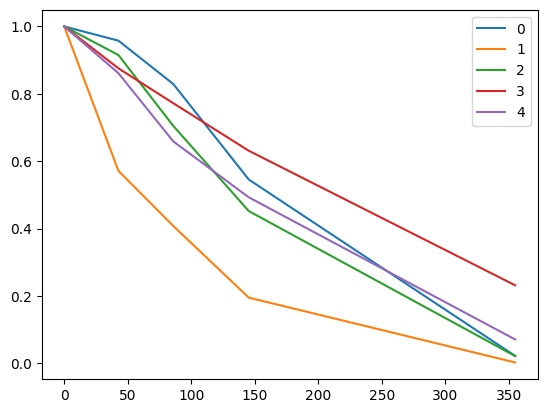

In [14]:
surv.iloc[:, :5].plot()

In [15]:
df_y_test.head(5)

,duration,event
1529,128.366669,1
911,13.800000,1
1735,274.033325,0
1669,295.333344,1
111,119.466667,1
